Using device: cuda
holding out 600 samples from class 9 for OOD testing
Using 5400 total samples for training/validation.
augmenting 0% of the data
finished augmenting the data… now we have 4320 training samples
Training samples: 4320, Validation samples: 1080
Starting training!
Epoch 1/40 - Train Loss: 1.5316, Train Acc: 0.5502
Validation Loss: 1.1994 ///// Validatoin Accuracy: 0.7000
*** New best validation accuracy: 0.7000 ***
Epoch 2/40 - Train Loss: 0.7930, Train Acc: 0.9079
Validation Loss: 0.7002 ///// Validatoin Accuracy: 0.9444
*** New best validation accuracy: 0.9444 ***
Epoch 3/40 - Train Loss: 0.6699, Train Acc: 0.9583
Validation Loss: 0.7373 ///// Validatoin Accuracy: 0.9315
Epoch 4/40 - Train Loss: 0.6201, Train Acc: 0.9722
Validation Loss: 0.7051 ///// Validatoin Accuracy: 0.9398
Epoch 5/40 - Train Loss: 0.5895, Train Acc: 0.9852
Validation Loss: 0.5868 ///// Validatoin Accuracy: 0.9843
*** New best validation accuracy: 0.9843 ***
Epoch 6/40 - Train Loss: 0.5541, Train A

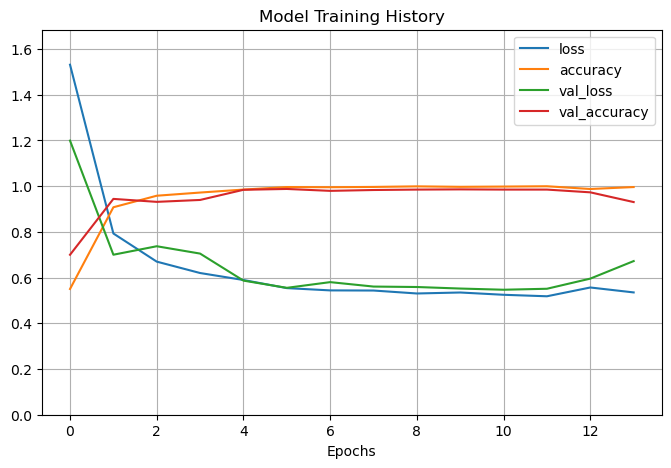



Validation Accuracy (best weights): 0.9880
Combined OOD calibration set size 600
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-


Calculating Energy Scores of in distribution set
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

Calculating MC Logits for 1080 samples
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Finished calculating all MC logits.. now returning the average logits

Calculatin

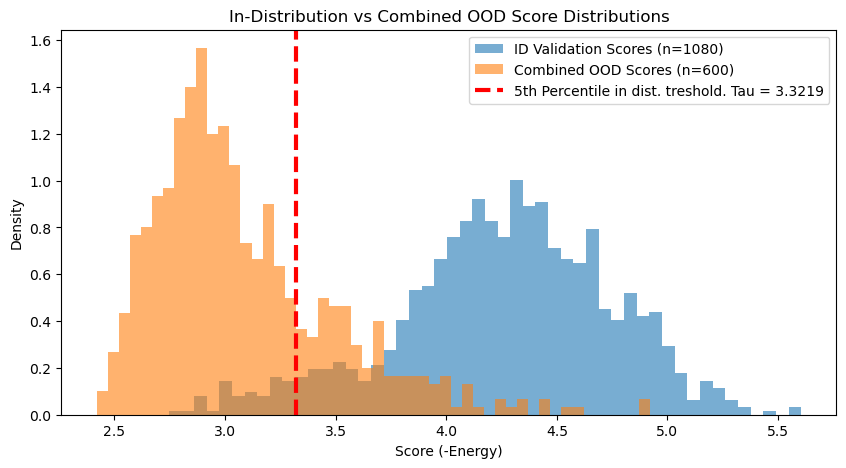

Threshold (@5% ID): 3.3219
TPR @ Threshold (ID): 0.9500
FPR @ Threshold (Combined OOD): 0.2283
AUROC (ID Val vs Combined OOD): 0.9551


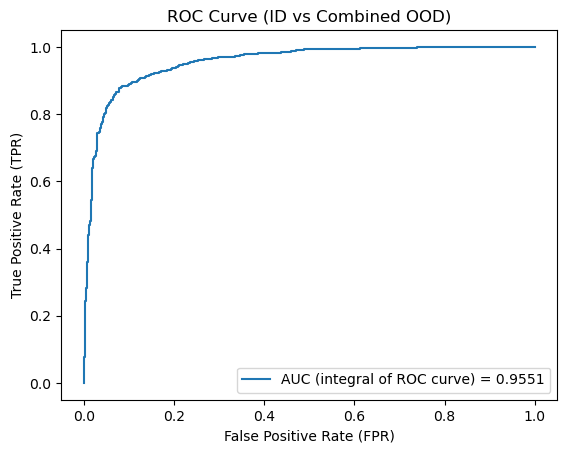


Running Predictions with OOD detection...

Calculating MC Logits for 8 samples
....................
Finished calculating all MC logits.. now returning the average logits


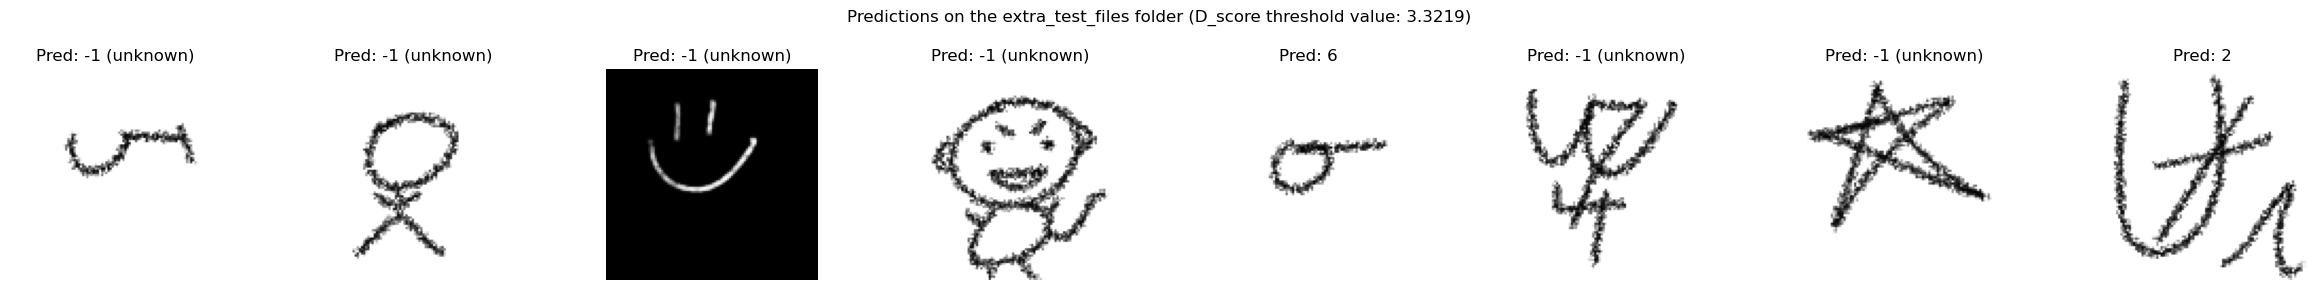


Predicting on random validation images...

Calculating MC Logits for 50 samples
........................................
Finished calculating all MC logits.. now returning the average logits


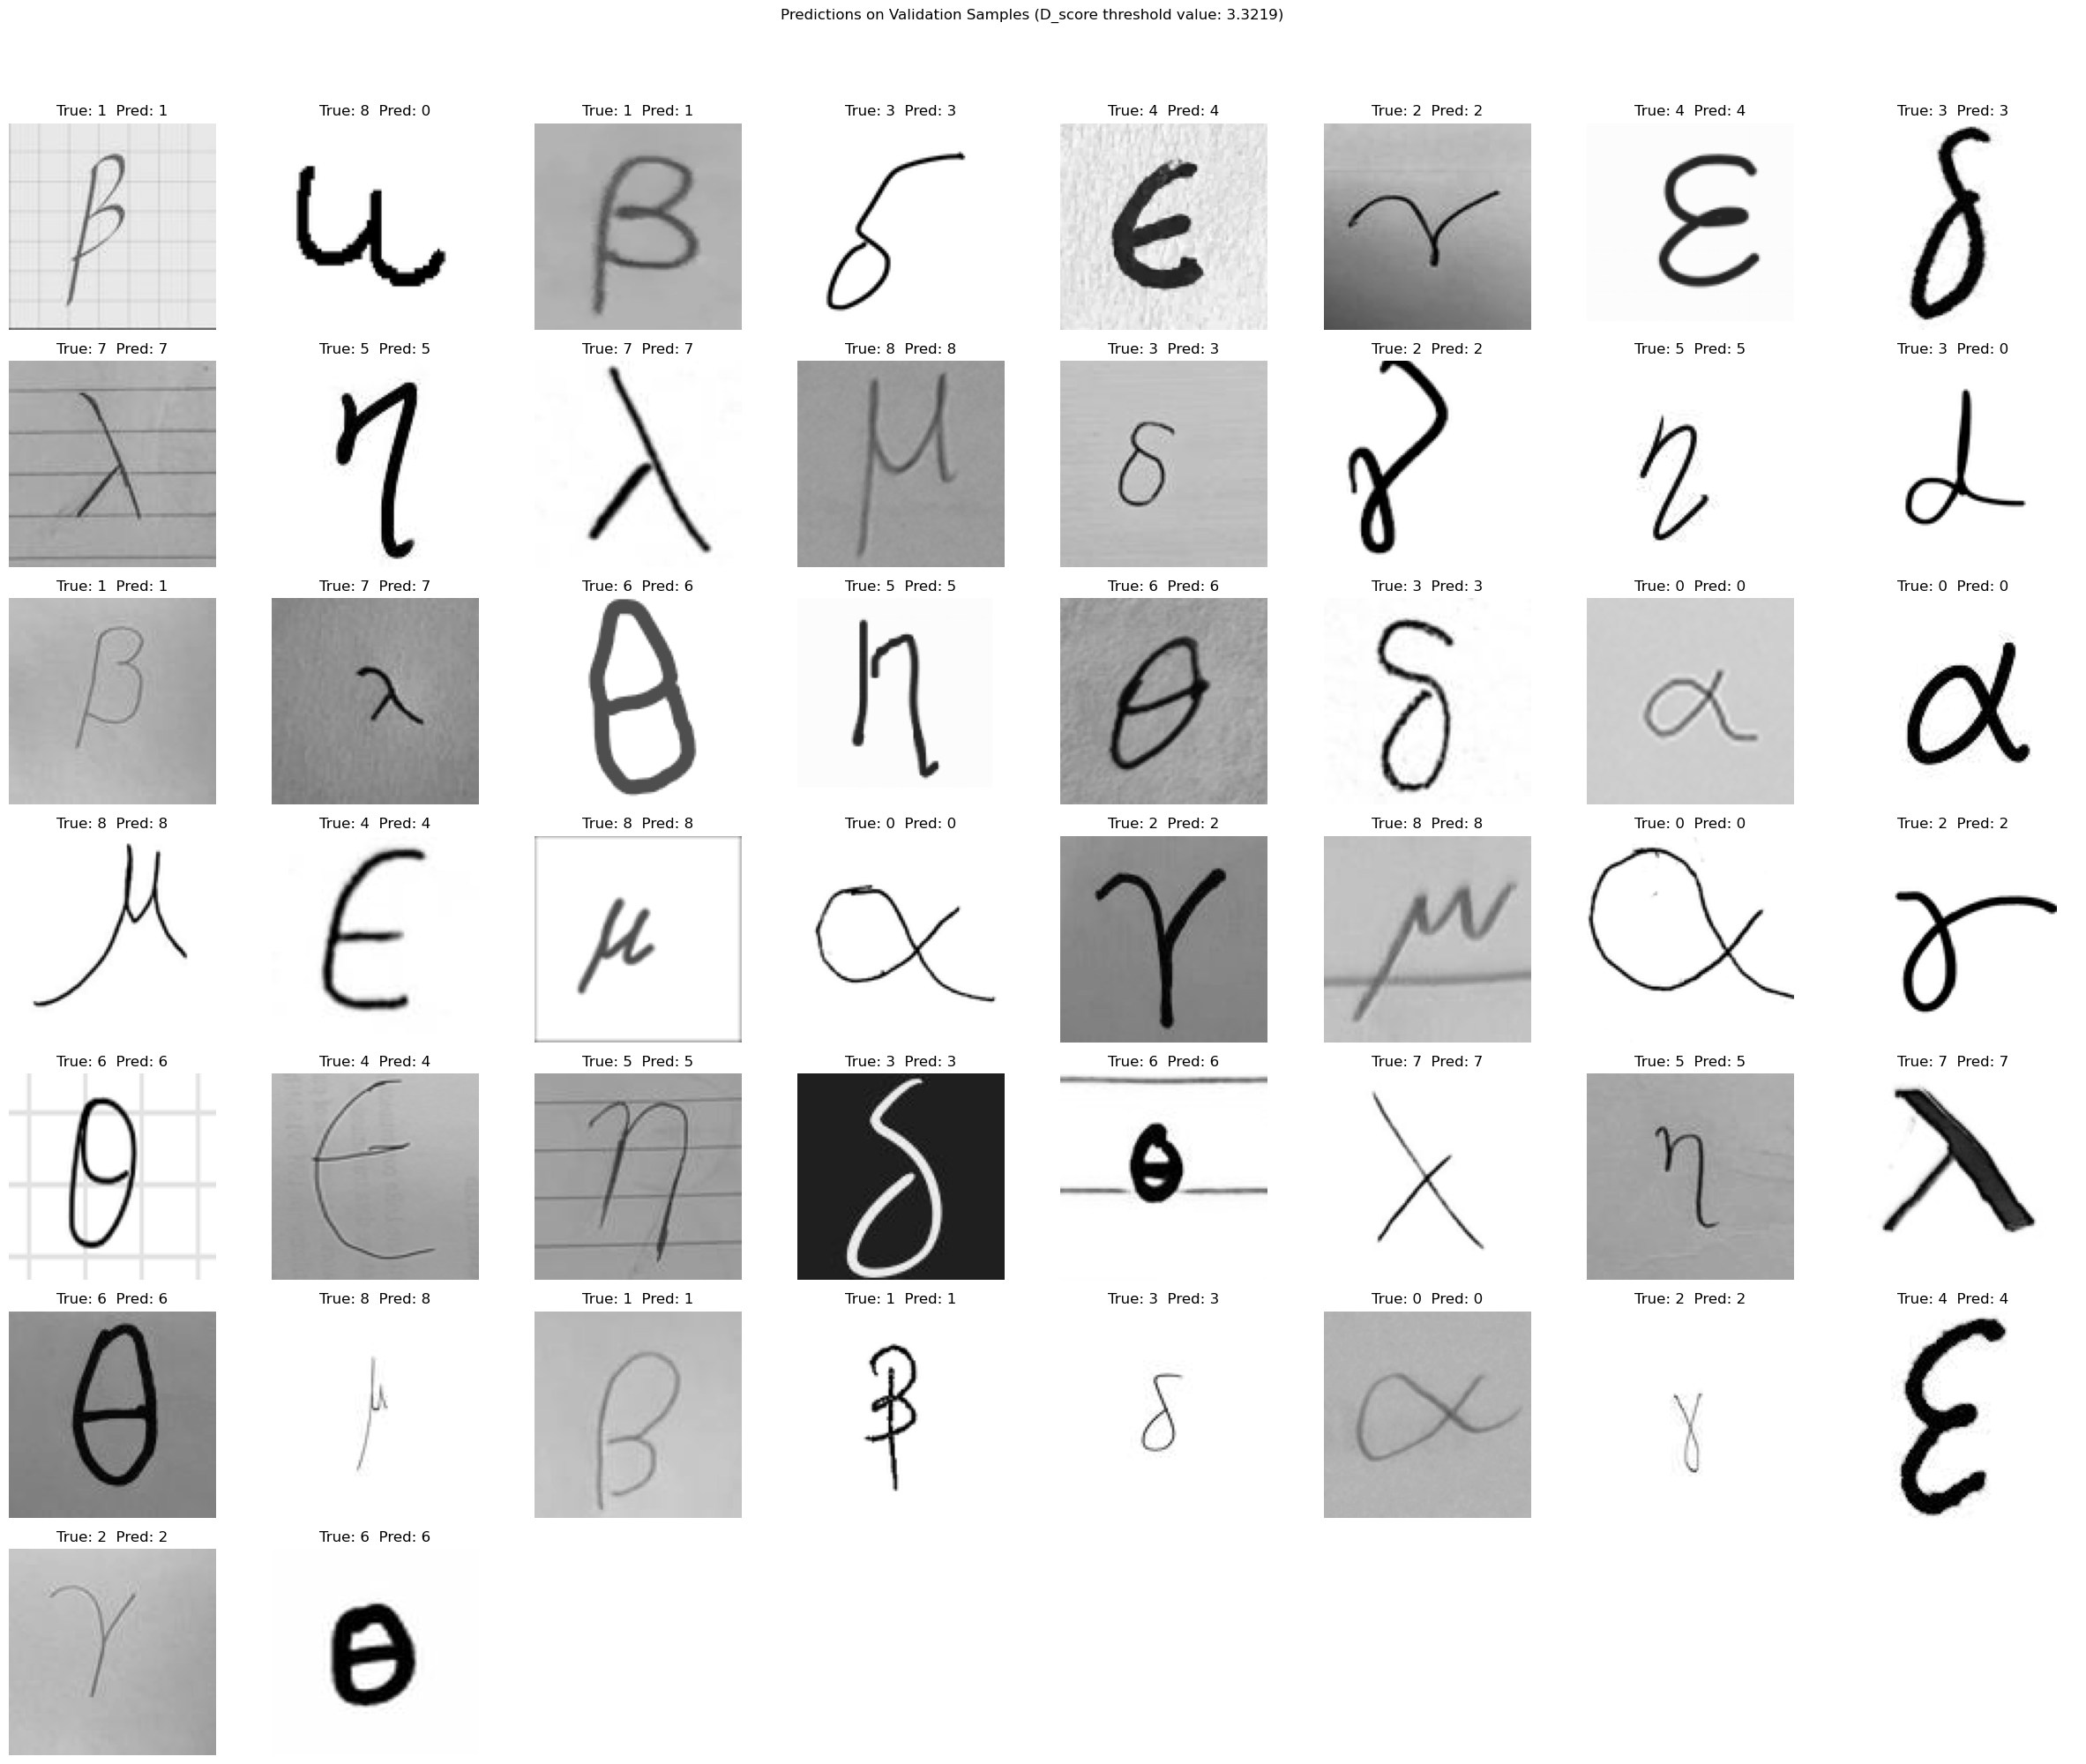

In [1]:
import os, glob, time, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from skimage.transform import rotate
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# -=-=-=-=-=-=-=-=-=-=-=--==-
# Configure hyperparameters here!
# -=-=-=-=-=-=-=-=-=-=-=--==-
BASE_NUM_FILTERS = 70 # BASE_NUM_FILTERS = 132 may give ~0.4 more performance and better OOD detection, but I'm not sure yet. I have to do more testing
DROPOUT_RATE = 0.25
LEARNING_RATE = 1e-3 # KEEP FIXED: 1e‑4 and smaller LR hurts our validation accuracys
prop = 0 # proportion of the training set to augment (0 => no augmentation)
LABEL_SMOOTHING = 0.1
MONTE_CARLO_PASSES = 20 # (20 seems good) number of stochastic forward passes for MC dropout
THRESHOLD_PERCENTILE = 5 # Use n-th percentile of in distribution scores for tuning the distribution score threshold

NUM_MNIST_OOD_SAMPLES = 0 # number of inverted MNIST images for OOD testing
HELD_OUT_CLASS = 9 # which class we want to leave out for OOD testing

NUM_EPOCHS = 40
BATCH_SIZE = 32

EARLY_STOPPING_PATIENCE = 8
# -=-=-=-=-=-=-=-=-=-=-=--==-


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# setting all the random seeds to 0
# tf.random.set_seed(0)
torch.manual_seed(0)

torch.cuda.manual_seed_all(0)

np.random.seed(0)
random.seed(0)


# -=-=-=-=-=-=-=-=-=-=-=--==-
# SECTION 1
# Load the data
# -=-=-=-=-=-=-=-=-=-=-=--==-

# ---------- LOAD PROJECT DATA ----------

all_labels_np = pd.read_csv("t_train_project.csv", header=None)[0].to_numpy(int)
all_images_np = pd.read_csv("x_train_project.csv", header=None).to_numpy(np.float32).reshape(-1, 1, 100, 100)

all_images_np = all_images_np / 255.0 # normalize the 0-255 pixel values to be between 0 and 1

# hold out a particular class‑9 for OOD testing (we want to test if the model recognizes that this is a symbol we've never seen before without relying on environmental details such as the paper or average intensity of the training set)
indices_to_hold_out_class = np.where(all_labels_np == HELD_OUT_CLASS)[0] # returns a tuple and we want the first one, which contains the array of indices of our target class
np.random.shuffle(indices_to_hold_out_class) # shuffle and then take a subset below

# now put all of the class 9 into the OOD set
indices_to_hold_out_class_ood = indices_to_hold_out_class[0:]

training_mask = np.ones_like(all_labels_np, bool)
training_mask[indices_to_hold_out_class_ood] = False # exclude the held‑out indices

id_images_placed_ood_np = all_images_np[indices_to_hold_out_class_ood]
print(f"holding out {len(id_images_placed_ood_np)} samples from class {HELD_OUT_CLASS} for OOD testing")

images_train_raw_np, labels_train_raw_np = all_images_np[training_mask], all_labels_np[training_mask]
print(f"Using {len(images_train_raw_np)} total samples for training/validation.")

# 80 / 20 validation split (stratified) - keep using sklearn for this
images_train_base, images_validation_np, labels_train_base, labels_validation_np = train_test_split(
    images_train_raw_np, labels_train_raw_np, test_size=0.2, stratify=labels_train_raw_np, random_state=0
)

images_train_base_tensor = torch.from_numpy(images_train_base).float()
labels_train_base_tensor = torch.from_numpy(labels_train_base).long() # need to use long for cross entropy loss, error otherwise
images_validation_tensor = torch.from_numpy(images_validation_np).float()
labels_validation_tensor = torch.from_numpy(labels_validation_np).long()
id_images_placed_ood_tensor = torch.from_numpy(id_images_placed_ood_np).float()

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# SECTION 2
# DATA AUGMENTATION (intensity + rotation)
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
def vary_intensity(X_normalized_np, y_np, proportion=0.2, intensity_min = 0.5, intensity_max = 1.5):
    # proportion = proportion of the X_normalized dataset to impute
    # intensity_min is the minimum possible multiplication factors for the pixel intensity
    # intensity_max is the max possible factor (upper range of gaussian)
    num_samples_to_impute = int(np.floor(proportion*len(X_normalized_np)))

    if num_samples_to_impute == 0:
        return (np.empty((0, 1, 100, 100), dtype=X_normalized_np.dtype), np.empty((0,), dtype=y_np.dtype))  # returns empty X and y arrays w/ appropriate dimensions

    indices = np.random.choice(len(X_normalized_np), num_samples_to_impute, replace=False) # reaplce = False ensures sampels arent picked again (don't put back into possible selection)

    X_augmented = []
    y_augmented = []

    for i in indices:
        factor = np.random.uniform(intensity_min, intensity_max)
        img_adjusted = np.clip(X_normalized_np[i] * factor, 0.0, 1.0) # resets to max 1 (normalizes it again)
        X_augmented.append(img_adjusted)
        y_augmented.append(y_np[i]) # add back in the original label
    # output dimensions are (num_augmented, height, width, channels AKA 1 channel)
    return np.array(X_augmented), np.array(y_augmented)

def vary_rotation(X_normalized_np, y_np, proportion=0.2, angle_min=-30, angle_max=30):
    num_samples_to_impute = int(np.floor(proportion*len(X_normalized_np)))

    # Return empty arrays with correct shape if no augmentation
    if num_samples_to_impute == 0:
        return (np.empty((0, 1, 100, 100), dtype=X_normalized_np.dtype), np.empty((0,), dtype=y_np.dtype))

    indices = np.random.choice(len(X_normalized_np), num_samples_to_impute, replace=False) # reaplce = False ensures sampels arent picked again (don't put back into possible selection)

    X_augmented = []
    y_augmented = []

    for i in indices:
        img_2d = X_normalized_np[i].squeeze()
        angle = np.random.uniform(angle_min, angle_max)
        # preserve_range True tells skimage to not resize the output image dimensions to fit
        # the full rotated image, so we may **clip some data in the corners!!**
        # mode=edge fills in the new space introduced by the rotation with the pixel values found at the edge
        # preserve_range keeps the pixel values in [0,1] rather than [0,255]
        rotated_img_2d = rotate(img_2d, angle, resize=False, mode='edge', preserve_range=True) # outputs (100,00)
        X_augmented.append(rotated_img_2d.reshape(1, 100, 100)) # need to reshape to add that nested [] pixel intensity value (the dimension with size 1 in the tensor shape)
        y_augmented.append(y_np[i]) # add back in the original label
    # output dimensions are (num_augmented, height, width, channels AKA 1 channel)
    return np.array(X_augmented), np.array(y_augmented)

def vary_strech(X_normalized, y, proportion=0.2,intensity_max=1.6,intensity_min=0.2):
     # proportion = proportion of the X_normalized dataset to impute
    # intensity_max is the max possible factor the image is being streched. (upper range of gaussian)
    num_samples_to_impute = int(np.floor(proportion*len(X_normalized)))

    if num_samples_to_impute == 0:
        return (np.empty((0, 1, 100, 100), dtype=X_normalized.dtype), np.empty((0,), dtype=y.dtype))

    indices = np.random.choice(len(X_normalized), num_samples_to_impute, replace=False) # reaplce = False ensures sampels arent picked again (don't put back into possible selection)

    #Declaring Empty Lists for storing Augmented Images:
    X_augmented = []
    y_augmented = []

    for i in indices:

        factor = np.random.uniform(intensity_min, intensity_max)

        original_image = X_normalized[i]
        original_image = np.transpose(original_image, (1, 2, 0))
        
        oheight, owidth = original_image.shape[:2]
        oratio = owidth / oheight

        eratio=factor*oratio;
        if oratio > eratio:
          # Extend height
          eheight = int(owidth / eratio)
          extended_image = np.ones((eheight, owidth,1), dtype=original_image.dtype)
          extended_image[:oheight, :,:] = original_image.copy()
        else:
          # Extend width
          ewidth = int(oheight * eratio)
          extended_image = np.ones((oheight, ewidth,1), dtype=original_image.dtype)
          extended_image[:, :owidth,:] = original_image.copy()

        # Stretch back to 100x100:
        # Convert to torch tensor and resize to 100x100
        resized = resize(extended_image, (100, 100, 1), order=1, mode='reflect', preserve_range=True, anti_aliasing=True)
        resized = resized.astype(np.float32)  # keep it in [0, 1]

        X_augmented.append(resized)
        y_augmented.append(y[i])

        # add back in the original label
        # output dimensions are (num_augmented, height, width, channels AKA 1 channel)

    # but we need the pixel intensity dimensions to be in index 1
    X_augmented = np.transpose(np.array(X_augmented), (0, 3, 1, 2))  # (N, 100, 100, 1) → (N, 1, 100, 100)
    return np.array(X_augmented), np.array(y_augmented)

print(f"augmenting {prop*100}% of the data")
images_aug_intensity, labels_aug_intensity = vary_intensity(images_train_base, labels_train_base, proportion=prop / 3)
images_aug_rotation, labels_aug_rotation = vary_rotation(images_train_base, labels_train_base, proportion=prop / 3)
images_aug_stretch, labels_aug_stretch = vary_strech(images_train_base, labels_train_base, proportion = prop / 3)

images_train = np.concatenate([images_train_base, images_aug_intensity, images_aug_rotation, images_aug_stretch], axis=0)
labels_train = np.concatenate([labels_train_base, labels_aug_intensity, labels_aug_rotation, labels_aug_stretch], axis=0)

print(f"finished augmenting the data… now we have {len(images_train)} training samples")

images_train = torch.from_numpy(images_train).float()
labels_train = torch.from_numpy(labels_train).long()
print(f"Training samples: {len(images_train)}, Validation samples: {len(images_validation_tensor)}")

# create the tensor datasets and the dataloaders
train_dataset = TensorDataset(images_train, labels_train)
val_dataset = TensorDataset(images_validation_tensor, labels_validation_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# putting the entire validation set as one batch!
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# SECTION 3  – Model Definition (Residual CNN)
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, projection=False):
        super(ResidualBlock, self).__init__()
        self.projection = projection

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # inplace=True removes the need to create a hard copy in memory, otherwise GPU OOM error
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # the shortcut path for the residual block
        if self.projection:
            self.shortcut_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
            self.shortcut_bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        shortcut = x

        if self.projection:
            shortcut = self.shortcut_conv(x)
            shortcut = self.shortcut_bn(shortcut)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, base_num_filters, dropout_rate):
        super(ResNet, self).__init__()
        self.in_channels = base_num_filters

        # initial layers
        self.conv1 = nn.Conv2d(1, base_num_filters, kernel_size=7, stride=2, padding=3, bias=False) # 1 for the grayscale (1 channel)
        self.bn1 = nn.BatchNorm2d(base_num_filters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # all the residual blocks
        # downsample on some blocks to project down in feature space (for more generalization)
        self.layer1 = self.make_layer(base_num_filters, downsample=False)
        self.layer2 = self.make_layer(base_num_filters * 2, downsample=True)
        self.layer3 = self.make_layer(base_num_filters * 2, downsample=False)
        self.layer4 = self.make_layer(base_num_filters * 4, downsample=True)
        self.layer5 = self.make_layer(base_num_filters * 4, downsample=False)

        # final layers (global pooling average)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_num_filters * 4, 10)

    def make_layer(self, out_channels, downsample):
        # makes a resiodual block
        # if we downsample, then we need to set the stride to 2 pixels rather than one
        if downsample:
            stride = 2
        else:
            stride = 1
        
        if downsample or (self.in_channels != out_channels):
            projection = True
        else:
            projection = False

        block = ResidualBlock(self.in_channels, out_channels, stride=stride, projection=projection)
        self.in_channels = out_channels
        return block

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x) # RAW LOGITS
        return x

model = ResNet(BASE_NUM_FILTERS, DROPOUT_RATE).to(device)
# print(model)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# SECTION 4  – Training
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# early stopping code
best_val_accuracy = 0.0
epochs_without_improvement = 0
best_model_state = None

history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

print("Starting training!")
for epoch in range(NUM_EPOCHS):
    model.train()
    
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # moving the data to the device
        optimizer.zero_grad()
        raw_logits = model(inputs) # Get raw logits
        loss = criterion(raw_logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(raw_logits, 1)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += labels.size(0)


    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc.item()) # .item gets the python float instead of the tensor

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # VALIDATION MODE
    model.eval()
    
    val_running_loss = 0.0
    val_running_corrects = 0
    val_total_samples = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            raw_logits = model(inputs)
            loss = criterion(raw_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(raw_logits, 1)
            val_running_corrects += torch.sum(preds == labels.data)
            val_total_samples += labels.size(0)

    val_epoch_loss = val_running_loss / val_total_samples
    val_epoch_acc = val_running_corrects.double() / val_total_samples
    history['val_loss'].append(val_epoch_loss)
    history['val_accuracy'].append(val_epoch_acc.item())

    print(f"Validation Loss: {val_epoch_loss:.4f} ///// Validatoin Accuracy: {val_epoch_acc:.4f}")

    # early stopping check
    if val_epoch_acc > best_val_accuracy:
        best_val_accuracy = val_epoch_acc
        epochs_without_improvement = 0
        best_model_state = model.state_dict() # Save the best model state
        print(f"*** New best validation accuracy: {best_val_accuracy:.4f} ***")
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print("finished training")

# use the best model's weights
print(f"Using the best models weights with validation accuracy {best_val_accuracy:.4f}")
model.load_state_dict(best_model_state)

# plotting the learning curves

history_df = pd.DataFrame(history)
history_df.plot(figsize=(8, 5))
plt.grid(True)

ylim_top = max(1.1, history_df["loss"].max() * 1.1)
plt.gca().set_ylim(0, ylim_top)

plt.title("Model Training History")
plt.xlabel("Epochs")
plt.show()

print(f"\n\nValidation Accuracy (best weights): {best_val_accuracy:.4f}")

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# SECTION 5
# OOD Setup and Score Calculation
# See the Distribution Score of the in distirbution classes' data
# See the Distribution Score of the held out class data
# And the distirbution score of the MNIST data (if applicable)
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Initialize images_mnist_ood as an empty array with the correct shape
images_mnist_ood_np = np.empty((0, 1, 100, 100), dtype=np.float32)

if NUM_MNIST_OOD_SAMPLES > 0: # Only run MNIST part if count > 0
    mnist_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(), # this scales for us already!! Sets to [0,1]
        transforms.Lambda(lambda x: 1.0 - x) # inverts the colors
    ]))

    selected_indices = np.random.choice(len(mnist_test_dataset), NUM_MNIST_OOD_SAMPLES, replace=False) # picks random MNIST numbers from this
    mnist_ood_subset = Subset(mnist_test_dataset, selected_indices)

    mnist_inverted_list = []
    for item in mnist_ood_subset:
        mnist_inverted_list.append(item[0])

    images_mnist_ood_tensor = torch.stack(mnist_inverted_list).float()
    images_mnist_ood_np = images_mnist_ood_tensor.numpy() # convert back to numpy for concatenation
    print(f"generated {len(images_mnist_ood_np)} inverted MNIST samples.")


# Combine OOD samples: only include MNIST count > 0
if NUM_MNIST_OOD_SAMPLES > 0 and len(images_mnist_ood_np) > 0:
    images_ood_combined = np.concatenate([id_images_placed_ood_np, images_mnist_ood_np], axis=0)
else:
    images_ood_combined = id_images_placed_ood_np # if no MNIST, then only use the ID images taken OOD

if len(images_ood_combined) > 0:
    np.random.shuffle(images_ood_combined)
print(f"Combined OOD calibration set size {len(images_ood_combined)}")

images_ood_combined_tensor = torch.from_numpy(images_ood_combined).float()

# --------  getting the energy and Distribution scores of in-dist, MNIST OOD, and hold-out OOD sets -------
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nCalculating Energy Scores of in distribution set")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")

def energy(logits_tensor):
    # log‑sum‑exp across the MC‑averaged logits
    return -torch.logsumexp(logits_tensor, dim=1) #shape (N, num_classes)


def get_average_logits(data_tensor, batch_size=32):
    # Compute mean logits over MONTE_CARLO_PASSES-many stochastic forward passes
    logits_runs_list = []
    num_samples = data_tensor.shape[0]
    temp_dataset = TensorDataset(data_tensor)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size)

    print(f"\nCalculating MC Logits for {num_samples} samples")
    model.train()

    with torch.no_grad():
        for i in range(MONTE_CARLO_PASSES):
            batch_logits_list = []
            for (batch,) in temp_loader:
                batch = batch.to(device)
                batch_logits = model(batch).detach().cpu() # remove from GPU graph and then put it into the CPU because we're building and storing unneccesary gradients otherwise (too much GPU memory usage)
                batch_logits_list.append(batch_logits)
                print(".", end="")
            run_logits = torch.cat(batch_logits_list, dim=0)
            logits_runs_list.append(run_logits)

    model.eval()
    print("\nFinished calculating all MC logits.. now returning the average logits")

    all_logits_tensor = torch.stack(logits_runs_list)
    avg_logits_tensor = torch.mean(all_logits_tensor, dim=0)
    return avg_logits_tensor

# ID & OOD scores
validation_logits_tensor = get_average_logits(images_validation_tensor, batch_size=BATCH_SIZE)
id_scores_tensor = -energy(validation_logits_tensor) # id scores of validation set for tuning
id_scores = id_scores_tensor.numpy()

# Initialize OOD scores/logits empty arryas
ood_logits_tensor = torch.empty((0, 10), dtype=torch.float32)
ood_scores_tensor = torch.tensor([], dtype=torch.float32)
ood_scores = ood_scores_tensor.numpy()

if len(images_ood_combined_tensor) > 0:
    ood_logits_tensor = get_average_logits(images_ood_combined_tensor, batch_size=BATCH_SIZE) # not for tuning, but for comparison... get the logits of the ood images as well
    ood_scores_tensor = -energy(ood_logits_tensor)
    ood_scores = ood_scores_tensor.numpy()

plt.figure(figsize=(10, 5))

plt.hist(
    id_scores,
    bins=50,
    alpha=0.6,
    label=f"ID Validation Scores (n={len(id_scores)})",
    density=True,
)

if len(ood_scores) > 0:
    plt.hist(
        ood_scores,
        bins=50,
        alpha=0.6,
        label=f"Combined OOD Scores (n={len(ood_scores)})",
        density=True,
    )

tau_threshold_value = np.percentile(id_scores, THRESHOLD_PERCENTILE) # gets the threshold (min) value of the Distribution Score for in-distribution classification
plt.axvline(tau_threshold_value, color="r", linestyle="dashed", linewidth=3, label=f"{THRESHOLD_PERCENTILE}th Percentile in dist. treshold. Tau = {tau_threshold_value:.4f}") # creates a red dotted line to show where we cut it off, formatted value
plt.xlabel("Score (-Energy)")
plt.ylabel("Density")
plt.title("In‑Distribution vs Combined OOD Score Distributions")
plt.legend()
plt.show()

# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# Compute TPR, FPR, and then the ROC curve for plots
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
if len(ood_scores) > 0:
    # calculqting the FPR with found tau
    false_positive_count = 0
    for score in ood_scores:
        if score >= tau_threshold_value:
            false_positive_count += 1
    false_positive_rate_at_tau = false_positive_count / len(ood_scores)

    # now calculate TPR
    tp_count = 0
    for score in id_scores:
        if score >= tau_threshold_value:
            tp_count += 1
    true_positive_rate_at_tau = tp_count / len(id_scores)

    # combine all the labels and the D_score scores for the roc_curve function, which automatically iterates over values of Tau for us
    labels_concat = []
    all_scores_concat = []

    for i in id_scores:
        labels_concat.append(1) # counts how many in distr scores we have
    for i in ood_scores:
        labels_concat.append(0) # counts how many out of distr scores we have
    for score in id_scores:
        all_scores_concat.append(score) # at the corresponding indices, add in the in-distr scores
    for score in ood_scores:
        all_scores_concat.append(score) # at the corresponding indices add in the out of distr scores

    fpr_curve, tpr_curve, roc_thresholds = roc_curve(labels_concat, all_scores_concat) # automatically tests for threshold values and provides the fpr and tpr values for graph
    auroc_value = auc(fpr_curve, tpr_curve) # gets the area under the curve of the ROC curve

    print(f"Threshold (@{THRESHOLD_PERCENTILE}% ID): {tau_threshold_value:.4f}")
    print(f"TPR @ Threshold (ID): {true_positive_rate_at_tau:.4f}")
    print(f"FPR @ Threshold (Combined OOD): {false_positive_rate_at_tau:.4f}")
    print(f"AUROC (ID Val vs Combined OOD): {auroc_value:.4f}")

    plt.plot(fpr_curve, tpr_curve, label=f"AUC (integral of ROC curve) = {auroc_value:.4f}")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve (ID vs Combined OOD)")
    plt.legend()
    plt.show()

# ---------- INFERENCE WITH OOD ----------
print("\nRunning Predictions with OOD detection...")

def predict_with_ood_detection(batch_input_tensor):
    batch_input_tensor = batch_input_tensor.to(device)
    model.to(device)

    averaged_logits_tensor = get_average_logits(batch_input_tensor)
    batch_scores_tensor = -energy(averaged_logits_tensor)

    # get class predictions from logits
    class_predictions_tensor = torch.argmax(averaged_logits_tensor, dim=1)

    # Convert scores and predictions to NumPy for easier comparison/string formatting
    batch_scores_np = batch_scores_tensor.cpu().numpy()
    class_predictions_np = class_predictions_tensor.cpu().numpy()

    results = []
    for score, pred in zip(batch_scores_np, class_predictions_np):
        results.append("-1 (unknown)" if score < tau_threshold_value else str(pred))
    return results

png_paths = sorted(glob.glob("extra_test_files/*.png"))
images_png_np_list = []

# the code below should take any image in the extra test file and get it to the right dimensions
for file_path in png_paths:
    img = plt.imread(file_path)
    if img.ndim == 3:
        img = img[..., 0] # strip the RGB colors and use grayscale channel only
    if img.shape != (100, 100): # resize to 100x100 images if not already
         img_tensor = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)
         img_tensor_resized = F.interpolate(img_tensor, size=(100, 100), mode='bilinear', align_corners=False)
         img = img_tensor_resized.squeeze().numpy() # Remove the extra dimensions
        
    if img.max() > 1.1:
         img = img / 255.0 # normalize if not already normalized
        
    images_png_np_list.append(img)

if images_png_np_list:
    X_png_np = np.stack(images_png_np_list)[:, np.newaxis, ...].astype(np.float32)
    X_png_tensor = torch.from_numpy(X_png_np)

    predictions_png = predict_with_ood_detection(X_png_tensor)
    
    cols = 8 # how many images are in the folder
    num_images_png = len(images_png_np_list)
    rows = int(np.ceil(num_images_png / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), squeeze=False)
    axes = axes.flatten()

    for idx, (img, label) in enumerate(zip(images_png_np_list, predictions_png)):
        if idx < len(axes):
            axes[idx].imshow(img, cmap="gray", vmin=0, vmax=1)
            axes[idx].set_title(f"Pred: {label}")
            axes[idx].axis("off")

    for idx in range(num_images_png, len(axes)): # turn off remaining axes on empty plots
         if idx < len(axes):
            axes[idx].axis("off")

    plt.suptitle(f"Predictions on the extra_test_files folder (D_score threshold value: {tau_threshold_value:.4f})")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("extra_test_files empty")

if NUM_MNIST_OOD_SAMPLES > 0:
    
    print("\nPredicting on random inverted MNIST images...")

    if 'images_mnist_ood_tensor' not in locals() or images_mnist_ood_tensor.shape[0] != NUM_MNIST_OOD_SAMPLES:
        mnist_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
         transforms.Resize((100, 100)),
         transforms.ToTensor(),
         transforms.Lambda(lambda x: 1.0 - x)
        ]))
        selected_indices = np.random.choice(len(mnist_test_dataset), NUM_MNIST_OOD_SAMPLES, replace=False)
        mnist_ood_subset = Subset(mnist_test_dataset, selected_indices)
        
        mnist_inverted_list = []
        for item in mnist_ood_subset:
            mnist_inverted_list.append(item[0])


        images_mnist_ood_tensor = torch.stack(mnist_inverted_list).float()
        print(f"Re-generated {len(images_mnist_ood_tensor)} inverted MNIST samples for prediction.")

    n_test_digits = 10 # How many to display
    
    if n_test_digits > images_mnist_ood_tensor.shape[0]:
        n_test_digits = images_mnist_ood_tensor.shape[0]

    if n_test_digits > 0:
        mnist_predictions = predict_with_ood_detection(images_mnist_ood_tensor[:n_test_digits]) # only predict on the first n_test_digits

        fig, axes = plt.subplots(1, n_test_digits, figsize=(2 * n_test_digits, 2.5))

        # Ensure axes is always iterable even if n_test_digits is 1 by wrapping in list
        if n_test_digits == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for idx, (img_tensor, lab) in enumerate(zip(images_mnist_ood_tensor[:n_test_digits], mnist_predictions)):
            if idx < len(axes):
                 axes[idx].imshow(img_tensor.squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=1)
                 axes[idx].set_title(f"Pred: {lab}")
                 axes[idx].axis("off")
        plt.suptitle(f"Predictions on Inverted MNIST (D_score threshold value: {tau_threshold_value:.4f})")
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.show()


# 50 random validation images
print("\nPredicting on random validation images...")
num_val_display = 50
if num_val_display > len(images_validation_tensor):
    num_val_display = len(images_validation_tensor)

if num_val_display > 0:
    # Use the tensors directly
    random_val_indices = np.random.choice(len(images_validation_tensor), num_val_display, replace=False)
    validation_sample_images_tensor = images_validation_tensor[random_val_indices]
    validation_sample_labels_np = labels_validation_np[random_val_indices] # Use numpy labels for true display

    validation_predictions = predict_with_ood_detection(validation_sample_images_tensor)

    cols = 8
    rows = int(np.ceil(num_val_display / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows), squeeze=False)
    axes = axes.flatten()

    for idx in range(num_val_display):
         if idx < len(axes):
            # Convert tensor to numpy for plotting
            img_np = validation_sample_images_tensor[idx].cpu().numpy().squeeze()
            axes[idx].imshow(img_np, cmap="gray", vmin=0, vmax=1)
            axes[idx].set_title(f"True: {validation_sample_labels_np[idx]}  Pred: {validation_predictions[idx]}")
            axes[idx].axis("off")

    # hide the axes of the remaining empty subplots
    for idx in range(num_val_display, len(axes)):
         if idx < len(axes):
            axes[idx].axis("off")
    plt.suptitle(f"Predictions on Validation Samples (D_score threshold value: {tau_threshold_value:.4f})")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# right off the bat, it seems like stretching the images (at least to the degree we are stretching it) might be increasing our FPR.
# I think it may be expanding the space of in-distribuition representations too much. We might want to experiment with smaller stretch amounts

In [2]:
# condensed some of the trainnig and folding curve here for the experiments 

def train_resnet_fold(training_indices, validation_indices, images, labels, base_number_of_filters):
    images_tensor = images if torch.is_tensor(images) else torch.from_numpy(images)
    labels_tensor = labels if torch.is_tensor(labels) else torch.from_numpy(labels)
    
    network_model = ResNet(base_number_of_filters, DROPOUT_RATE).to(device)
    
    loss_function = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer_algorithm = optim.Adam(network_model.parameters(), lr=LEARNING_RATE)
    
    training_dataset = TensorDataset(images_tensor[training_indices].float(), labels_tensor[training_indices].long())
    
    validation_dataset = TensorDataset(images_tensor[validation_indices].float(), labels_tensor[validation_indices].long())
    training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
    
    best_accuracy = 0.0
    early_stopping_counter = 0
    for epoch_index in range(NUM_EPOCHS):
        network_model.train()
        for batch_images, batch_labels in training_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            optimizer_algorithm.zero_grad()
            predictions = network_model(batch_images)
            loss = loss_function(predictions, batch_labels)
            loss.backward()
            optimizer_algorithm.step()
        
        network_model.eval()
        correct_predictions_count = 0
        total_predictions_count = 0
        with torch.no_grad():
            for batch_images, batch_labels in validation_loader:
                batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
                validation_predictions = network_model(batch_images).argmax(dim=1)
                correct_predictions_count += (validation_predictions == batch_labels).sum().item()
                total_predictions_count += batch_labels.size(0)
        
        current_accuracy = correct_predictions_count / total_predictions_count
        
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                break
    
    return best_accuracy

In [3]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Experiment 1a – 15+ model sizes w/ 5‑fold cross validation
# Testing only in-distribution accuracy (i.e. easy test set)
# Using all 10 classes
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

from sklearn.model_selection import StratifiedKFold

model_sizes = [4, 8, 13, 17, 22, 26, 33, 39, 44, 55, 61, 66, 72, 83, 92]
avg_accuracies = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for size_id, size in enumerate(model_sizes):
    print(f"\n-=-=-=-=-=- MODEL SIZE {size} ({size_id+1}/15) -=-=-=-=-=-=-")
    fold_accuracies = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(images_train, labels_train), 1):
        torch.cuda.empty_cache()
        acc = train_resnet_fold(tr_idx, va_idx, images_train, labels_train, size)
        fold_accuracies.append(acc)
        print(f"fold {fold} validation accuracy: {acc:.6f}")
    mean_acc = np.mean(fold_accuracies)
    avg_accuracies.append(mean_acc)
    print(f"\n Done! Size {size}'s avg val accuracy = {mean_acc:.6f}")

plt.plot(range(1, 16), avg_accuracies, marker="o")
plt.xticks(range(1, 16), labels=model_sizes)
plt.xlabel("Model Size (BASE_NUM_FILTERS)")
plt.ylabel("Avg Validation Accuracy")
plt.title("Model Size vs Avg 5‑Fold Validation Accuracy")
plt.grid(True)
plt.show()


-=-=-=-=-=- MODEL SIZE 4 (1/15) -=-=-=-=-=-=-
fold 1 validation accuracy: 0.943287
fold 2 validation accuracy: 0.958333
fold 3 validation accuracy: 0.935185
fold 4 validation accuracy: 0.930556
fold 5 validation accuracy: 0.956019

 Done! Size 4's avg val accuracy = 0.944676

-=-=-=-=-=- MODEL SIZE 8 (2/15) -=-=-=-=-=-=-
fold 1 validation accuracy: 0.983796
fold 2 validation accuracy: 0.979167


KeyboardInterrupt: 

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Experiment 1b – 11 model sizes w/ 5‑fold cross validation
# Testing only in-distribution accuracy (i.e. easy test set)
# Using all 10 classes
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

model_sizes = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
avg_accuracies = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for size_id, size in enumerate(model_sizes):
    print(f"\n-=-=-=-=-=- MODEL SIZE {size} ({size_id+1}/11) -=-=-=-=-=-=-")
    fold_accuracies = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(images_train, labels_train), 1):
        torch.cuda.empty_cache()
        acc = train_resnet_fold(tr_idx, va_idx, images_train, labels_train, size)
        fold_accuracies.append(acc)
        print(f"fold {fold} validation accuracy: {acc:.6f}")
    mean_acc = np.mean(fold_accuracies)
    avg_accuracies.append(mean_acc)
    print(f"\n Done! Size {size}'s avg val accuracy = {mean_acc:.6f}")

plt.plot(range(1, 12), avg_accuracies, marker="o")
plt.xticks(range(1, 12), labels=model_sizes)
plt.xlabel("Model Size (BASE_NUM_FILTERS)")
plt.ylabel("Avg Validation Accuracy")
plt.title("Model Size vs Avg 5‑Fold Validation Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Experiment 2 – In-distribution accuracy vs augmentation
# 8 proportions of augmentation w/ 5‑fold CV
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

augmentation_proportions = np.linspace(0, 1, 8)
mean_accuracies_aug = []
BASE_NUM_FILTERS = 70
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for prop_idx, aug_val in enumerate(augmentation_proportions, 1):
    print(f"\n-=-=-=-=-=- Augmentation proportion {aug_val} ({prop_idx}/8) -=-=-=-=-=-=-")
    img_int, lbl_int = vary_intensity(images_train_base, labels_train_base, proportion=aug_val/3)
    img_rot, lbl_rot = vary_rotation(images_train_base, labels_train_base, proportion=aug_val/3)
    img_str, lbl_str = vary_strech(images_train_base, labels_train_base, proportion=aug_val/3)
    imgs_aug = np.concatenate([images_train_base, img_int, img_rot, img_str], axis=0)
    lbls_aug = np.concatenate([labels_train_base, lbl_int, lbl_rot, lbl_str], axis=0)
    fold_acc = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(imgs_aug, lbls_aug), 1):
        torch.cuda.empty_cache()
        acc = train_resnet_fold(tr_idx, va_idx, imgs_aug, lbls_aug, BASE_NUM_FILTERS)
        fold_acc.append(acc)
        print(f"fold {fold} validation accuracy: {acc:.6f}")
    mean_acc = np.mean(fold_acc)
    mean_accuracies_aug.append(mean_acc)
    print(f"\n Done! Augmentation proportion {aug_val} avg val accuracy = {mean_acc:.6f}")

plt.plot(augmentation_proportions, mean_accuracies_aug, marker="o")
plt.xlabel("Augmentation proportions")
plt.ylabel("Avg Vailidation Accuracy")
plt.title("Proportion of Data Augmented vs Validation Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Experiment 3 – OOD detection metrics vs model size
# Using 20 monte carlo passes
# -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

from sklearn.model_selection import StratifiedKFold
import gc

model_sizes = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

TPR_scores = []
FPR_scores = []
AUROC_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for size_id, size in enumerate(model_sizes, 1):
    print(f"\n-=-=-=-=-=- MODEL SIZE {size} ({size_id}/11) -=-=-=-=-=-=-")
    fold_tpr = []
    fold_fpr = []
    fold_auc = []
    for fold, (tr_idx, va_idx) in enumerate(skf.split(images_train, labels_train), 1):
        torch.cuda.empty_cache()
        _ = train_resnet_fold(tr_idx, va_idx, images_train, labels_train, size)
        
        id_scores_tensor = -energy(get_average_logits(images_train[va_idx].float()))
        ood_scores_tensor = -energy(get_average_logits(torch.from_numpy(images_ood_combined).float()))

        id_scores = id_scores_tensor.cpu().numpy()
        ood_scores = ood_scores_tensor.cpu().numpy()
        
        tau = np.percentile(id_scores, THRESHOLD_PERCENTILE)
        fold_tpr.append((id_scores >= tau).mean())
        fold_fpr.append((ood_scores >= tau).mean())
        labels_concat = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
        scores_concat = np.concatenate([id_scores, ood_scores])
        auroc = auc(*roc_curve(labels_concat, scores_concat)[:2])
        fold_auc.append(auroc)
    TPR_scores.append(np.mean(fold_tpr))
    FPR_scores.append(np.mean(fold_fpr))
    AUROC_scores.append(np.mean(fold_auc))
    print(f"avg TPR={TPR_scores[-1]:.4f} avg FPR={FPR_scores[-1]:.4f} avg AUROC={AUROC_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(model_sizes, TPR_scores, marker="o")
axes[0].set_title("TPR @ 5th Percentile")
axes[0].grid(True)

axes[1].plot(model_sizes, FPR_scores, marker="o")
axes[1].set_title("FPR @ 5th Percentile")
axes[1].grid(True)

axes[2].plot(model_sizes, AUROC_scores, marker="o")
axes[2].set_title("AUROC vs Model Size")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Experiment 4 – OOD metrics vs Monte-Carlo passes
# ============================================================

BASE_NUM_FILTERS = 70
mc_passes_list = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 40, 50]
indices_hold_out_class = np.where(all_labels_np == HELD_OUT_CLASS)[0]
np.random.shuffle(indices_hold_out_class)
images_ood_combined = all_images_np[indices_hold_out_class]
np.random.shuffle(images_ood_combined)
print(f"Final OOD set size (class {HELD_OUT_CLASS} only): {len(images_ood_combined)}")

TPR_scores = []
FPR_scores = []
AUROC_scores = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for idx_mc, mc_passes in enumerate(mc_passes_list, 1):
    print(f"\n-=-=-=-=-=- MC PASSES {mc_passes} ({idx_mc}/{len(mc_passes_list)}) -=-=-=-=-=-=-")
    MONTE_CARLO_PASSES = mc_passes
    
    fold_tpr = []
    fold_fpr = []
    fold_auc = []
    
    for fold, (tr_idx, va_idx) in enumerate(skf.split(images_train, labels_train), 1):
        torch.cuda.empty_cache()
        
        _ = train_resnet_fold(tr_idx, va_idx, images_train, labels_train, BASE_NUM_FILTERS)
        id_scores_tensor  = -energy(get_average_logits(images_train[va_idx].float()))
        ood_scores_tensor = -energy(get_average_logits(torch.from_numpy(images_ood_combined).float()))

        id_scores = id_scores_tensor.cpu().numpy()
        ood_scores = ood_scores_tensor.cpu().numpy()
        
        tau = np.percentile(id_scores, THRESHOLD_PERCENTILE)
        fold_tpr.append((id_scores >= tau).mean())
        fold_fpr.append((ood_scores >= tau).mean())
        labels_concat = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
        scores_concat = np.concatenate([id_scores, ood_scores])
        auroc = auc(*roc_curve(labels_concat, scores_concat)[:2])
        fold_auc.append(auroc)
    TPR_scores.append(np.mean(fold_tpr))
    FPR_scores.append(np.mean(fold_fpr))
    AUROC_scores.append(np.mean(fold_auc))
    print(f"avg TPR={TPR_scores[-1]:.4f} avg FPR={FPR_scores[-1]:.4f} avg AUROC={AUROC_scores[-1]:.4f}")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(mc_passes_list, TPR_scores, marker="o")
axes[0].set_title("TPR @ 5th Percentile")
axes[0].set_xlabel("Monte Carlo Passes")
axes[0].grid(True)

axes[1].plot(mc_passes_list, FPR_scores, marker="o")
axes[1].set_title("FPR @ 5th Percentile")
axes[1].set_xlabel("Monte Carlo Passes")
axes[1].grid(True)

axes[2].plot(mc_passes_list, AUROC_scores, marker="o")
axes[2].set_title("AUROC vs Monte Carlo Passes")
axes[2].set_xlabel("Monte Carlo Passes")
axes[2].grid(True)

plt.tight_layout()
plt.show()